In [1]:
#import rasterio
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import geopandas as gpd
import math 
import fiona
import rasterio
import shapely
from rasterio.plot import show

In [30]:
dsm_shp = gpd.read_file('data/dsm/DHMVII_vdc_k5.shp').reset_index()
dsm_shp = dsm_shp.set_crs('epsg:31370')
dsm_shp

,index,Date,OpnDatum1,OpnDatum2,geometry
0,0,20140319,2014-03-19,None,"POLYGON Z ((86000.000 230206.366 0.000, 85998...."
1,1,20140317,2014-03-19,2014-03-17,"POLYGON Z ((86000.000 230206.366 0.000, 86000...."
2,2,20140317,2014-03-17,None,"MULTIPOLYGON Z (((97000.000 228000.000 0.000, ..."
3,3,20140317,2014-03-17,2014-03-30,"MULTIPOLYGON Z (((95075.940 227675.980 0.000, ..."
4,4,20140330,2014-03-30,None,"POLYGON Z ((87000.000 227360.941 0.000, 87000...."
5,5,20140330,2014-03-30,2014-03-31,"MULTIPOLYGON Z (((67106.560 224569.260 0.000, ..."
6,6,20140331,2014-03-31,None,"POLYGON Z ((98000.000 224213.494 0.000, 98000...."
7,7,20140331,2014-03-31,2014-04-01,"MULTIPOLYGON Z (((66364.220 220127.500 0.000, ..."
8,8,20140401,2014-04-01,None,"POLYGON Z ((69144.125 219908.699 0.000, 69148...."
9,9,20140401,2014-04-01,2014-04-02,"POLYGON Z ((98000.000 219184.145 0.000, 98000...."


In [36]:
dsm_shp_geometry = dsm_shp.geometry.reset_index()
dsm_shp_dis = dsm_shp_geometry.dissolve(by='index')


,geometry
index,
0,"POLYGON Z ((86000.000 230206.366 0.000, 85998...."
1,"POLYGON Z ((86000.000 230206.366 0.000, 86000...."
2,"MULTIPOLYGON Z (((97000.000 228000.000 0.000, ..."
3,"MULTIPOLYGON Z (((95075.940 227675.980 0.000, ..."
4,"POLYGON Z ((87000.000 227360.941 0.000, 87000...."
5,"MULTIPOLYGON Z (((67106.560 224569.260 0.000, ..."
6,"POLYGON Z ((98000.000 224213.494 0.000, 98000...."
7,"MULTIPOLYGON Z (((78710.290 220136.130 0.000, ..."
8,"POLYGON Z ((69144.125 219908.699 0.000, 69148...."


In [13]:
# bruge coordinates decimal
lat_bruge = 51.209348
long_bruge = 3.224700

In [4]:
raster = rasterio.open('data/geotif/dsm/DHMVIIDSMRAS1m_k05.tif')
print(raster.crs)
print(raster.count)

EPSG:31370
1


<AxesSubplot:>

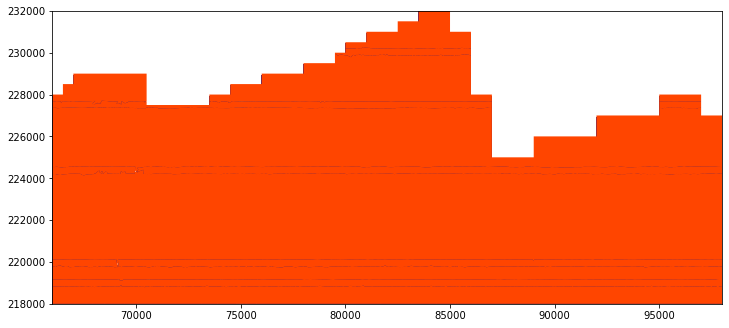

In [5]:
#show point and raster on a matplotlib plot
fig,ax = plt.subplots(figsize=(12,30))
dsm_shp.plot(ax=ax, color='orangered')
show(raster, ax=ax)

In [6]:
dsm_shp.bounds.head()

,minx,miny,maxx,maxy
0,80000.000033,230179.190125,86000.000033,232000.000025
1,79500.000033,229787.069925,86000.000033,230240.950025
2,66000.000033,227529.410025,97000.000033,229939.629925
3,66000.000033,227318.210125,97000.000033,227706.680025
4,66000.000033,224309.019925,98000.000033,227405.100125


In [14]:
import shapefile
from shapely.geometry import shape, Point

r = shapefile.Reader('data/dsm/DHMVII_vdc_k5.shp')
shapes = r.shapes()
polygon = shape(shapes[0])

def check(lon, lat):
    point = Point(lon,lat)
    return polygon.contains(point)

check(long_bruge, lat_bruge)

False

In [ ]:
# Ellipsoid parameters: semi major axis in metres, reciprocal flattening.
GRS80 = 6378137, 298.257222100882711
WGS84 = 6378137, 298.257223563

def geodetic_to_geocentric(ellipsoid, latitude, longitude, height):
    """Return geocentric (Cartesian) Coordinates x, y, z corresponding to
    the geodetic coordinates given by latitude and longitude (in
    degrees) and height above ellipsoid. The ellipsoid must be
    specified by a pair (semi-major axis, reciprocal flattening).

    """
    φ = radians(latitude)
    λ = radians(longitude)
    sin_φ = sin(φ)
    a, rf = ellipsoid           # semi-major axis, reciprocal flattening
    e2 = 1 - (1 - 1 / rf) ** 2  # eccentricity squared
    n = a / sqrt(1 - e2 * sin_φ ** 2) # prime vertical radius
    r = (n + height) * cos(φ)   # perpendicular distance from z axis
    x = r * cos(λ)
    y = r * sin(λ)
    z = (n * (1 - e2) + height) * sin_φ
    return x, y, z

In [ ]:
width = 800
height = 600

with rasterio.open('data/geotif/dsm/DHMVIIDSMRAS1m_k05.tif') as src:
    w = src.read(1, window=Window(0, 0, width, height))
    profile = src.profile
    profile['width'] = width
    profile['height'] = height
    # Create output
    result = np.full((width, height), dtype=profile['dtype'], fill_value=profile['nodata'])

#writting
with rasterio.open('/tmp/sampled_image.tif', 'w', **profile) as dataset:
    dataset.write_band(1, result)

#plotting
with rasterio.open('/tmp/sampled_image.tif') as src:
    pyplot.imshow(src.read(1), cmap='pink')
    pyplot.show()